
Found 5592 images belonging to 5 classes.
Found 2396 images belonging to 5 classes.
Class names: ['AmericanBashkirCurly', 'AmericanPaintHorse', 'BelgianDraft', 'Friesian', 'ShetlandPony']


Epoch 1/20


27/27 [==============================] - 522s 19s/step - loss: 1.2333 - accuracy: 0.5501 - val_loss: 1.8035 - val_accuracy: 0.3032
Epoch 2/20
27/27 [==============================] - 483s 18s/step - loss: 0.7166 - accuracy: 0.7389 - val_loss: 1.4041 - val_accuracy: 0.3836
Epoch 3/20
27/27 [==============================] - 483s 18s/step - loss: 0.5547 - accuracy: 0.7908 - val_loss: 1.4270 - val_accuracy: 0.3950
Epoch 4/20
27/27 [==============================] - 484s 18s/step - loss: 0.4780 - accuracy: 0.8225 - val_loss: 1.4199 - val_accuracy: 0.4123
Epoch 5/20
27/27 [==============================] - 484s 18s/step - loss: 0.4244 - accuracy: 0.8476 - val_loss: 1.2575 - val_accuracy: 0.4827
Epoch 6/20
27/27 [==============================] - 482s 18s/step - loss: 0.3687 - accuracy: 0.86

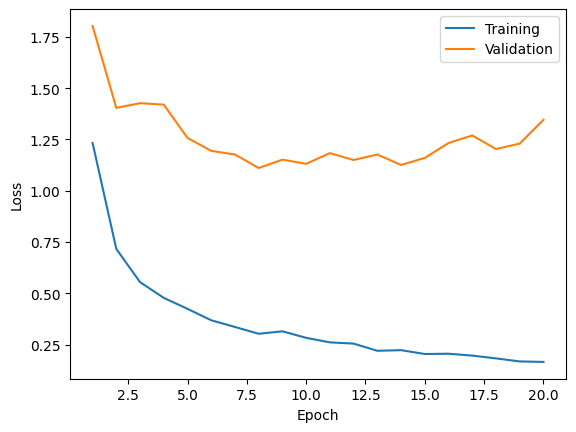

Model saved as models/horses_vgg19_10Epochs.keras
7/7 [==============================] - 13s 2s/step


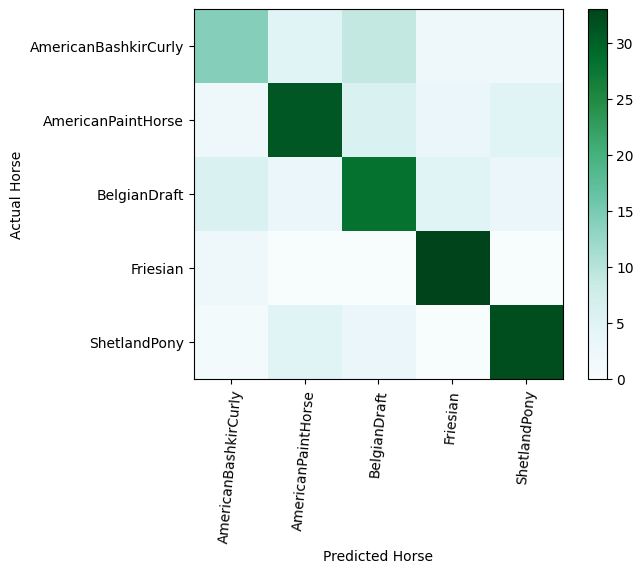

1/1 [==============================] - 0s 109ms/step
Prediction for ABC1.jpg: [[1. 0. 0. 0. 0.]] Class: AmericanBashkirCurly
Prediction for ABC2.jpg: [[1. 0. 0. 0. 0.]] Class: AmericanBashkirCurly
Prediction for ABC3.jpg: [[0. 0. 0. 0. 1.]] Class: ShetlandPony
Prediction for ABC4.jpg: [[1. 0. 0. 0. 0.]] Class: AmericanBashkirCurly
Prediction for AP1.jpg: [[0. 1. 0. 0. 0.]] Class: AmericanPaintHorse
Prediction for AP2.jpg: [[0. 1. 0. 0. 0.]] Class: AmericanPaintHorse
Prediction for AP3.jpg: [[0. 1. 0. 0. 0.]] Class: AmericanPaintHorse
Prediction for AP4.jpg: [[0. 1. 0. 0. 0.]] Class: AmericanPaintHorse
Prediction for BD1.jpg: [[1. 0. 0. 0. 0.]] Class: AmericanBashkirCurly
Prediction for BD2.jpg: [[0.0000000e+00 1.0000000e+00 0.0000000e+00 1.1831475e-08 0.0000000e+00]] Class: AmericanPaintHorse
Prediction for BD3.jpg: [[0. 0. 1. 0. 0.]] Class: BelgianDraft
Prediction for BD4.jpg: [[0. 0. 1. 0. 0.]] Class: BelgianDraft
Prediction for F1.jpg: [[0. 0. 0. 1. 0.]] Class: Friesian
Prediction f

In [1]:
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Set your data folder and parameters
data_folder = 'BigDataset/horse_photos'
pretrained_size = (224, 224)
batch_size = 200

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

classnames = sorted(os.listdir(data_folder))
print("Class names:", classnames)

# Load the VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
predictions = keras.layers.Dense(len(classnames), activation='softmax')(x)

model = keras.models.Model(inputs=base_model.input, outputs=predictions)

learning_rate = 0.0001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Train the model
num_epochs = 20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=num_epochs
)

# Plot training and validation loss
epoch_nums = range(1, num_epochs + 1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Save the trained model
modelFileName = 'models/horses_vgg19_10Epochs.keras'
model.save(modelFileName)
del model
print('Model saved as', modelFileName)

# Load the saved model for inference
model = keras.models.load_model('models/horses_vgg19_10Epochs.keras')

# Generate predictions from validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]
class_probabilities = model.predict(x_test)
predictions = np.argmax(class_probabilities, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.BuGn)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Horse")
plt.ylabel("Actual Horse")
plt.show()

# Inference on new images
image_folder = './inferencing - Copy'
image_files = os.listdir(image_folder)

img_width, img_height = 224, 224

preprocessed_images = []
for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    img = keras.preprocessing.image.load_img(img_path, target_size=(img_width, img_height))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    preprocessed_images.append(img_preprocessed)

predictions = [model.predict(img) for img in preprocessed_images]

# Display predictions
for i, img_file in enumerate(image_files):
    index = int(np.argmax(predictions[i], axis=1)[0])
    print(f"Prediction for {img_file}: {predictions[i]} Class: {classnames[index]}")


In [2]:
image_folder = './inferencing - Copy'
image_files = os.listdir(image_folder)

img_width, img_height = 224, 224

preprocessed_images = []
for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    img = keras.preprocessing.image.load_img(img_path, target_size=(img_width, img_height))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    preprocessed_images.append(img_preprocessed)

predictions = [model.predict(img) for img in preprocessed_images]

# Display predictions
for i, img_file in enumerate(image_files):
    index = int(np.argmax(predictions[i], axis=1)[0])
    print(f"Prediction for {img_file}: {predictions[i]} Class: {classnames[index]}")

1/1 [==============================] - 0s 111ms/step
Prediction for ABC1.jpg: [[1. 0. 0. 0. 0.]] Class: AmericanBashkirCurly
Prediction for ABC2.jpg: [[1. 0. 0. 0. 0.]] Class: AmericanBashkirCurly
Prediction for ABC3.jpg: [[0. 0. 0. 0. 1.]] Class: ShetlandPony
Prediction for ABC4.jpg: [[1. 0. 0. 0. 0.]] Class: AmericanBashkirCurly
Prediction for AP1.jpg: [[0. 1. 0. 0. 0.]] Class: AmericanPaintHorse
Prediction for AP2.jpg: [[0. 1. 0. 0. 0.]] Class: AmericanPaintHorse
Prediction for AP3.jpg: [[0. 1. 0. 0. 0.]] Class: AmericanPaintHorse
Prediction for AP4.jpg: [[0. 1. 0. 0. 0.]] Class: AmericanPaintHorse
Prediction for BD1.jpg: [[1. 0. 0. 0. 0.]] Class: AmericanBashkirCurly
Prediction for BD2.jpg: [[0.0000000e+00 1.0000000e+00 0.0000000e+00 1.1831475e-08 0.0000000e+00]] Class: AmericanPaintHorse
Prediction for BD3.jpg: [[0. 0. 1. 0. 0.]] Class: BelgianDraft
Prediction for BD4.jpg: [[0. 0. 1. 0. 0.]] Class: BelgianDraft
Prediction for F1.jpg: [[0. 0. 0. 1. 0.]] Class: Friesian
Prediction f